# Necessary Imports
In this section, we will import the necessary libraries for training our Convolutional Neural Network (rf) model. This includes libraries for data manipulation, model building, and evaluation.

In [2]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import joblib
from joblib import dump, load
import seaborn as sns

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score
)
from sklearn.utils import class_weight, compute_class_weight
from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

from tensorflow.keras.models import load_model  

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# sklearn Model and Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Image Loading and Preprocessing Functions
We shall create several functions for loading and preprocessing images from a specified directory. The functions perform the following tasks:

1. **Check if a file is an image:** A helper function that determines if a given filename has an image file extension (specifically `.jpg`).

2. **Load and preprocess an image:** A function that loads an image from a specified path, resizes it to a target size (defaulting to 128x128 pixels), normalizes pixel values to be between 0 and 1, and ensures that the image has three color channels (RGB).

3. **Load images from a directory:** A function that walks through a specified directory, loads and preprocesses images, and assigns them a label (either fraudulent or non-fraudulent) based on the provided input.

4. **Set base directory and load training images:** The base directory for the dataset is specified, along with paths to the training data subdirectories for fraudulent and non-fraudulent images. The training images are then loaded and labeled accordingly.

In [4]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [5]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [6]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


# Load Fraud and Non-Fraud Images from the Train Directories
In this section, the previously loaded training images for fraud and non-fraud cases are assigned to variables for denoising:
- `fraud_images` is set to `train_images_fraud`.
- `non_fraud_images` is set to `train_images_non_fraud`.

In [9]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

# Aggressive Augmentation of Fraud Images
To address the class imbalance in the dataset, we create the `augment_fraud_images` function, which enhances the number of fraud images through aggressive data augmentation. This approach serves two key purposes:

1. **Handling Dataset Imbalance:**  
   Fraud detection datasets often suffer from an imbalance, with a significant scarcity of fraud cases compared to non-fraud cases. Augmenting the existing fraud images ensures a more diverse dataset, helping the model generalize better and perform effectively in fraud detection.

2. **Aggressive Augmentation for Enhanced Variability:**  
   The function applies aggressive transformations, such as rotation, shifting, and zooming, to generate more diverse versions of the fraud images. This approach mitigates overfitting to specific patterns in the small fraud set and helps the model learn robust, transferable features for fraud detection.

### Augmentation Functions

- **Mixup Function:**  
   The `mixup` function blends two images together using a randomized lambda value to generate a weighted combination of the two images.

- **CutMix Function:**  
   The `cutmix` function cuts a random portion of one image and replaces it with the corresponding section from another image.

- **Attention CutMix Function:**  
   The `attn_cutmix` function uses an attention map to guide the selection of regions for the CutMix operation, focusing on areas of high interest as determined by the attention map.

These augmentation techniques are used to increase the variability and diversity of the fraud images, ultimately improving the model's ability to generalize and detect fraud more effectively.

In [11]:
# mixup function
def mixup(image1, image2, alpha=0.2):
    lambda_ = np.random.beta(alpha, alpha)
    return lambda_ * image1 + (1 - lambda_) * image2

# cutMix function
def cutmix(image1, image2):
    h, w, c = image1.shape
    cut_x = np.random.randint(w // 2)
    cut_y = np.random.randint(h // 2)
    rect_h = h // 4
    rect_w = w // 4

    image1[cut_y:cut_y + rect_h, cut_x:cut_x + rect_w] = image2[cut_y:cut_y + rect_w, cut_x:cut_x + rect_h]
    return image1

# Attn-CutMix function
def attn_cutmix(image1, image2, attention_map=None):
    h, w, c = image1.shape
    if attention_map is None:  # Dummy attention map if not provided
        attention_map = np.random.rand(h, w)
    
    # determine region of interest (ROI) from attention map
    roi_y, roi_x = np.unravel_index(np.argmax(attention_map), attention_map.shape)
    rect_h = h // 4
    rect_w = w // 4
    
    # apply CutMix based on ROI
    image1[roi_y:roi_y + rect_h, roi_x:roi_x + rect_w] = image2[roi_y:roi_y + rect_h, roi_x:roi_x + rect_w]
    return image1

# Function for Aggressive Augmentation of Fraud Images

This function, `augment_fraud_images`, aggressively augments fraud images to address class imbalance in the dataset. It applies various augmentation techniques and calculates the Mean Squared Error (MSE) to assess the changes between the original and augmented images. Here's how it works:

1. **Data Augmentation:**  
   The function uses `ImageDataGenerator` from Keras to apply several aggressive transformations to the fraud images, including:
   - Rotation (up to 90 degrees)
   - Width and height shifts (up to 40%)
   - Shear and zoom ranges (up to 50%)
   - Horizontal flip

2. **Augmentation Techniques:**  
   The following augmentation methods are randomly chosen for each image:
   - **Standard Augmentation:** Basic transformations like rotation, shifts, etc., applied using the `ImageDataGenerator`.
   - **Mixup:** A weighted blend of two randomly chosen images.
   - **CutMix:** A portion of one image is replaced with a corresponding region from another image.
   - **Attention CutMix:** CutMix applied using a randomly generated attention map to focus on specific regions of interest.

3. **Mean Squared Error (MSE):**  
   After each augmentation, the function computes the MSE between the original image and the augmented image, providing a measure of how much transformation occurred. The average MSE is printed to track the degree of change introduced during augmentation.

4. **Looping Until Target Count:**  
   The function continues augmenting the images until the specified `target_count` is reached, ensuring that there are enough augmented fraud images to balance the dataset.

5. **Return Value:**  
   Once the target number of augmented fraud images is generated, the function returns the augmented images along with the average MSE value.

This method enhances the diversity of the fraud images, which helps the model learn more generalized and robust features for fraud detection.

In [13]:
# function for aggressive augmentation of fraud images
def augment_fraud_images(fraud_images, target_count):
    datagen_fraud = ImageDataGenerator(
        rotation_range=90,  # aggressive rotation
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    
    augmented_fraud_images = []
    mse_list = []  # store MSE values here
    current_count = len(fraud_images)

    # augment images until we reach the target count
    while current_count < target_count:
        for i, img in enumerate(fraud_images):
            img = img.reshape((1,) + img.shape)  # reshape for the generator

            # Randomly choose an augmentation method
            method = np.random.choice(['standard', 'mixup', 'cutmix', 'attn_cutmix'])

            if method == 'standard':
                aug_img = next(datagen_fraud.flow(img))  # generate 1 image
                aug_img = aug_img[0]  # take the first augmented image
            
            elif method == 'mixup':
                img2 = fraud_images[np.random.randint(0, len(fraud_images))]
                aug_img = mixup(img[0], img2)
            
            elif method == 'cutmix':
                img2 = fraud_images[np.random.randint(0, len(fraud_images))]
                aug_img = cutmix(img[0], img2)
            
            elif method == 'attn_cutmix':
                img2 = fraud_images[np.random.randint(0, len(fraud_images))]
                attention_map = np.random.rand(img.shape[1], img.shape[2])  # Dummy attention map
                aug_img = attn_cutmix(img[0], img2, attention_map)

            augmented_fraud_images.append(aug_img)
            
            # calculate MSE between original and augmented image
            mse_value = mean_squared_error(img[0], aug_img)
            mse_list.append(mse_value)

            current_count += 1
            if current_count >= target_count:
                break

    # return augmented images and the average MSE
    avg_mse = np.mean(mse_list)
    print(f'Average MSE between original and augmented fraud images: {avg_mse}')
    return np.array(augmented_fraud_images)

# Balancing Fraud and Non-Fraud Images in the Dataset

In this section, we balance the number of fraud and non-fraud images in the dataset to ensure that the model is trained on an equal representation of both classes. This helps prevent bias towards the majority class (non-fraud) and improves the model's ability to detect fraud.

### Steps:
1. **Count of Non-Fraud Images:**  
   First, we determine the number of non-fraud images in the dataset by calculating `aug_rf_num_non_fraud_images`.

2. **Augmenting Fraud Images:**  
   If the number of fraud images is less than the number of non-fraud images, we use the `augment_fraud_images` function to generate additional fraud images. This function applies aggressive augmentations to create diverse versions of the original fraud images, ensuring the dataset is balanced.

3. **Combining Original and Augmented Fraud Images:**  
   After generating the augmented fraud images, we combine them with the original fraud images to form a balanced dataset where the number of fraud images equals the number of non-fraud images.

4. **No Augmentation Needed:**  
   If the number of fraud images is already greater than or equal to the number of non-fraud images, we skip the augmentation and use the original set of fraud images.

By following this approach, we ensure that both fraud and non-fraud images are equally represented in the dataset, allowing for more robust model training.

In [15]:
# number of non-fraud images
aug_rf_num_non_fraud_images = len(non_fraud_images)

# augment fraud images to balance the dataset
if len(fraud_images) < aug_rf_num_non_fraud_images:
    # augment fraud images to reach the number of non-fraud images
    aug_rf_augmented_fraud_images = augment_fraud_images(fraud_images, aug_rf_num_non_fraud_images)
    
    # combine original fraud images with the augmented fraud images
    aug_rf_combined_fraud_images = np.vstack((fraud_images, aug_rf_augmented_fraud_images))
else:
    # if we already have more or equal fraud images, no need to augment
    aug_rf_combined_fraud_images = fraud_images

Average MSE between original and augmented fraud images: 0.044300724371587


# Function to Balance the Dataset

To train machine learning models effectively, it is essential to have a balanced dataset where each class (fraud and non-fraud) is represented equally. The following function `balance_dataset` combines fraud and non-fraud images and labels them accordingly, ensuring that both classes are present in the final dataset.

### Steps:
1. **Combining Images:**  
   The function first combines the fraud and non-fraud images into a single dataset using `np.vstack`, stacking them vertically.

2. **Creating Labels:**  
   It assigns a label of `1` to fraud images and `0` to non-fraud images. These labels are stored in `fraud_labels` and `non_fraud_labels`.

3. **Combining Labels:**  
   The labels for both fraud and non-fraud images are then combined using `np.hstack`, horizontally stacking them to form a complete set of labels corresponding to the combined images.

4. **Returning Balanced Dataset:**  
   Finally, the function returns the combined images and the corresponding labels, which can be used for training machine learning models.

This ensures that the dataset is balanced and properly labeled for training.

In [17]:
# define a function to balance the dataset
def balance_dataset(fraud_images, non_fraud_images):
    # combine fraud and non-fraud images
    combined_images = np.vstack((fraud_images, non_fraud_images))
    
    # create labels for fraud (1) and non-fraud (0)
    fraud_labels = np.ones(fraud_images.shape[0])
    non_fraud_labels = np.zeros(non_fraud_images.shape[0])
    
    # combine the labels
    combined_labels = np.hstack((fraud_labels, non_fraud_labels))
    
    return combined_images, combined_labels

# Balance the Dataset

In this step, we use the `balance_dataset` function to create a balanced dataset of fraud and non-fraud images. This ensures that both classes are equally represented during model training, preventing the model from being biased toward the more abundant class.

The function combines the augmented fraud images (from the previous augmentation) and the original non-fraud images, labels them accordingly, and prepares them for training.

### Code Explanation:
- `aug_rf_combined_fraud_images`: This is the dataset containing both the original and augmented fraud images.
- `non_fraud_images`: The original set of non-fraud images.
- The function call to `balance_dataset` combines these two datasets and assigns appropriate labels (`1` for fraud, `0` for non-fraud), resulting in a balanced dataset for training.

This approach ensures the model is trained on a balanced distribution of both classes, improving its ability to detect fraud effectively.

In [19]:
# balance the dataset
aug_rf_balanced_images, aug_rf_balanced_train_labels = balance_dataset(
    aug_rf_combined_fraud_images, 
    non_fraud_images
)

# Calculate the Number of Fraud Images Needed to Balance the Dataset

To ensure a balanced dataset, the number of fraud images is adjusted to match the number of non-fraud images. After balancing, the combined dataset is split back into separate fraud and non-fraud image sets for further processing or analysis.

### Steps:
1. **Determine the Target Number of Fraud Images:**  
   The number of fraud images (`aug_rf_num_fraud_images`) is set equal to the number of non-fraud images to achieve balance.

2. **Split the Combined Dataset:**  
   - `aug_rf_balanced_fraud_images`: Contains the first `aug_rf_num_fraud_images` from the balanced dataset.
   - `aug_rf_balanced_non_fraud_images`: Contains the remaining images, corresponding to the non-fraud category.

This step ensures the dataset remains balanced while maintaining separate fraud and non-fraud image sets for subsequent tasks.

In [21]:
# calculate the number of fraud images needed to balance the dataset
aug_rf_num_fraud_images = len(non_fraud_images)  # number of fraud images should match the number of non-fraud images

# split the balanced images into fraud and non-fraud sets
aug_rf_balanced_fraud_images = aug_rf_balanced_images[:aug_rf_num_fraud_images]
aug_rf_balanced_non_fraud_images = aug_rf_balanced_images[aug_rf_num_fraud_images:]

# Denoising Function

This function utilizes a Deep Convolutional Autoencoder (DCAE) model to denoise fraudulent and non-fraudulent images. The denoising process enhances the quality of the images by removing noise, which can improve the performance of downstream machine learning models.

### Function Overview:

1. **Load the DCAE Model:**  
   - The function loads a pre-trained DCAE model from a specified path (`dcae_model_path`) to process the images.

2. **Denoise Images:**  
   - The `fraud_images` and `non_fraud_images` datasets are denoised using the model's prediction functionality.

3. **Provide Dataset Insights:**  
   - Prints the shapes of the denoised fraud and non-fraud datasets to verify the transformations and ensure consistency.

4. **Return Denoised Datasets:**  
   - Returns the processed datasets for both fraud and non-fraud images, ready for use in further analysis or training.

This function streamlines the integration of image denoising into the machine learning pipeline, ensuring better input quality for classification tasks.

In [23]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised = dcae_model.predict(fraud_images)
    non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised.shape}")

    return fraud_images_denoised, non_fraud_images_denoised

# Denoise the Balanced Fraud and Non-Fraud Images

In this step, the balanced fraud and non-fraud images are denoised using the pre-trained DCAE model. This enhances the image quality by reducing noise, which helps improve model performance in subsequent tasks such as classification.

### Steps:

1. **Load DCAE Model:**  
   - The function `denoise_images_with_dcae` is called with the file path `'dcae_model.keras'` to load the pre-trained denoising model.

2. **Denoise Images:**  
   - The function processes both `aug_rf_balanced_fraud_images` and `aug_rf_balanced_non_fraud_images` to generate denoised versions of the fraud and non-fraud images.

3. **Output Datasets:**  
   - The denoised fraud and non-fraud datasets are stored in `aug_rf_fraud_images_denoised` and `aug_rf_non_fraud_images_denoised`, respectively.

This denoising step ensures that both categories of images are of high quality, which can improve the accuracy and robustness of the machine learning models used in subsequent analysis.

In [25]:
# denoise the balanced fraud and non-fraud images
aug_rf_fraud_images_denoised, aug_rf_non_fraud_images_denoised = denoise_images_with_dcae(
    aug_rf_balanced_fraud_images, 
    aug_rf_balanced_non_fraud_images, 
    'dcae_model.keras'
)

DCAE model loaded.
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step
Denoised Fraud dataset shape: (6091, 128, 128, 3)
Denoised Non-Fraud dataset shape: (6091, 128, 128, 3)


# Combining Denoised Fraud and Non-Fraud Images
In this step, we combine the denoised fraud and non-fraud images into a single dataset and shuffle them for randomness. This process prepares the dataset for training machine learning models by ensuring that the classes are balanced and well-distributed.

### Steps:

1. **Combine Denoised Images:**  
   - The vertically stacked denoised fraud and non-fraud images (`aug_rf_fraud_images_denoised` and `aug_rf_non_fraud_images_denoised`) form a single dataset `aug_rf_balanced_images`.

2. **Shuffle the Combined Dataset:**  
   - Randomly generated indices corresponding to the total number of images are used to shuffle both `aug_rf_balanced_images` and their labels (`aug_rf_balanced_train_labels`).

3. **Verify the Shape:**  
   - The shapes of the combined image dataset and the label dataset are printed to ensure they align with the expected dimensions.

### Output:
- Combined and shuffled image dataset: `aug_rf_balanced_images`
- Corresponding labels: `aug_rf_balanced_train_labels`

In [27]:
# combine denoised fraud and non-fraud images, and shuffle
aug_rf_balanced_images = np.vstack((aug_rf_fraud_images_denoised, aug_rf_non_fraud_images_denoised))
indices = np.arange(aug_rf_balanced_images.shape[0])
np.random.shuffle(indices)

aug_rf_balanced_images = aug_rf_balanced_images[indices]
aug_rf_balanced_train_labels = aug_rf_balanced_train_labels[indices]

# verify the shape of generated images
print(f"Combined Fraud & Non-Fraud train dataset shape: {aug_rf_balanced_images.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {aug_rf_balanced_train_labels.shape}")

Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


# Preparing Data for Random Forest Classifier

To train the Random Forest classifier, the image data must be flattened into a 2D array format. The following steps are executed:

### Steps:

1. **Flatten Images:**  
   - Each image in the dataset `aug_rf_balanced_images` is reshaped into a single-dimensional array, resulting in a dataset `X_flat_aug_rf` with dimensions `(num_images, num_features)`.

2. **Prepare Labels:**  
   - The corresponding labels for the images are stored in `y_flat_aug_rf`.

3. **Split the Dataset:**  
   - The flattened dataset is split into training and validation sets using an 80-20 ratio, with stratification to ensure balanced class distribution.

### Outputs:
- **Flattened Training Data:** `X_train_flat_aug_rf` and `y_train_flat_aug_rf`
- **Flattened Validation Data:** `X_val_flat_aug_rf` and `y_val_flat_aug_rf`

In [29]:
# flatten the images for Random Forest
X_flat_aug_rf = aug_rf_balanced_images.reshape(aug_rf_balanced_images.shape[0], -1) 
y_flat_aug_rf = aug_rf_balanced_train_labels  # Use the correct label variable

# split the data
X_train_flat_aug_rf, X_val_flat_aug_rf, y_train_flat_aug_rf, y_val_flat_aug_rf = train_test_split(
    X_flat_aug_rf, y_flat_aug_rf, test_size=0.2, random_state=42, stratify=y_flat_aug_rf
)

# Applying PCA and Training the Random Forest Classifier

To improve computational efficiency and model performance, we apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset before training the Random Forest model.

### Steps:

1. **Apply PCA:**
   - Reduce the dataset to 50 principal components using PCA.
   - Fit and transform the training data, and transform the validation data.

2. **Define and Train Random Forest Model:**
   - Perform a hyperparameter grid search using `GridSearchCV` with 5-fold cross-validation.
   - The hyperparameter grid includes options for the number of estimators, maximum depth, minimum samples required for splits and leaves, and the number of features to consider for splits.

3. **Evaluate the Model:**
   - Identify the best hyperparameters and display the cross-validation F1 score.
   - Evaluate the model's performance on the validation set, providing a confusion matrix and a classification report.

4. **Save the Model and PCA:**
   - Save the trained Random Forest model and PCA transformer together in a file for future use.

### Outputs:
- **Best Hyperparameters:** Parameters that yielded the highest F1 score during cross-validation.
- **Validation Results:** Confusion matrix and classification report for validation predictions.
- **Saved Model:** PCA and trained Random Forest classifier saved as `rf_aug_with_pca.pkl`.

In [31]:
# apply PCA
pca_aug = PCA(n_components=50, random_state=42)
X_train_aug_pca = pca_aug.fit_transform(X_train_flat_aug_rf)  # fit and transform on training data
X_val_aug_pca = pca_aug.transform(X_val_flat_aug_rf)          # transform validation data

# define and train the Random Forest model
rf_classifier_aug_rf = RandomForestClassifier(random_state=42)

# hyperparameter grid to search
param_grid_aug = {
    'n_estimators': [25, 50, 75],            # number of trees
    'max_depth': [10, 20, 30, None],         # maximum depth of trees
    'min_samples_split': [2, 5, 10],         # minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']         # number of features to consider for splitting
}

# setup GridSearchCV with 5-fold cross-validation
grid_search_aug = GridSearchCV(
    estimator=rf_classifier_aug_rf, 
    param_grid=param_grid_aug, 
    cv=5, 
    n_jobs=1, 
    verbose=2, 
    scoring='f1'
)

# fit the model on the training data
grid_search_aug.fit(X_train_aug_pca, y_train_flat_aug_rf)

# display best hyperparameters and performance
print("Best Hyperparameters: ", grid_search_aug.best_params_)
print("Best Cross-Validation F1 Score: ", grid_search_aug.best_score_)

# evaluate the model with best hyperparameters on the validation set
best_aug_rf_classifier = grid_search_aug.best_estimator_
y_val_aug_pred = best_aug_rf_classifier.predict(X_val_aug_pca)

# print evaluation metrics
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val_flat_aug_rf, y_val_aug_pred))
print("Classification Report (Validation):\n", classification_report(y_val_flat_aug_rf, y_val_aug_pred))

# save PCA and Random Forest together
joblib.dump({'rf_classifier': best_aug_rf_classifier, 'pca': pca_aug}, 'rf_aug_with_pca.pkl')
print("Random Forest and PCA saved as rf_aug_with_pca.pkl")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; tot

# Loading Test Images and Labels
Here we define the paths to the test directories containing the fraud and non-fraud images. We then load and label the test images using the `load_images_from_directory` function, which retrieves the images from the specified directories and assigns the corresponding labels (1 for fraud and 0 for non-fraud).

### Test Directory Paths:
- **Fraud Images:** Path to the directory containing test fraud images.
- **Non-Fraud Images:** Path to the directory containing test non-fraud images.

In [33]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
aug_rf_test_images_fraud, aug_rf_test_labels_fraud = load_images_from_directory(test_fraud_dir, 1)
aug_rf_test_images_non_fraud, aug_rf_test_labels_non_fraud = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {aug_rf_test_images_fraud.shape}")
print(f"Test fraud labels shape: {aug_rf_test_labels_fraud.shape}")

print(f"Test images non_fraud shape: {aug_rf_test_images_non_fraud.shape}")
print(f"Test non_fraud labels shape: {aug_rf_test_labels_non_fraud.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


# Combining and Shuffling Test Images and Labels
In this step, we combine the test images and labels from both the fraud and non-fraud categories into single arrays. This ensures that we have a unified dataset for testing the model. 

### Steps:
1. **Concatenate Test Images and Labels:** The fraud and non-fraud images and their respective labels are concatenated along the first axis.
2. **Shuffle the Data:** To prevent any bias during testing, we generate an array of indices representing the sample positions and shuffle these indices randomly.
3. **Reorder Images and Labels:** The images and labels are reordered based on the shuffled indices to ensure a randomized test set.

In [35]:
# combine the test images and labels and shuffle
aug_rf_test_images = np.concatenate((aug_rf_test_images_fraud, aug_rf_test_images_non_fraud), axis=0)
aug_rf_test_labels = np.concatenate((aug_rf_test_labels_fraud, aug_rf_test_labels_non_fraud), axis=0)

# shuffle the test data rabdomly to prevent bias durign testing
indices = np.arange(aug_rf_test_images.shape[0]) # generate an array of indices representing the positions of the samples
np.random.shuffle(indices) # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
aug_rf_test_images = aug_rf_test_images[indices]
aug_rf_test_labels = aug_rf_test_labels[indices]

print(f"Combined test images: {aug_rf_test_images.shape}")
print(f"Combined test labels: {aug_rf_test_labels.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


# Reshaping Test Images for Evaluation

Before evaluating the test dataset, we reshape the test images to include the channels dimension (required for image-based models). Additionally, we verify the shapes of the reshaped test images and their corresponding labels.

### Steps:

1. **Reshape Test Images:**
   - Add the channels dimension to match the expected input format for the model (e.g., `(samples, 128, 128, 3)` for RGB images).

2. **Verify Shapes:**
   - Print the shapes of the reshaped test images and their predicted labels to ensure consistency.

In [37]:
# reshape to add the channels dimension
aug_rf_test_images_reshaped = aug_rf_test_images.reshape((-1, 128, 128, 3))

# verify the shape of the validation images and labels
print(f"Test Validation Images Shape: {aug_rf_test_images_reshaped.shape}")
print(f"Predicted Labels Shape: {aug_rf_test_labels.shape}")
   

Test Validation Images Shape: (1616, 128, 128, 3)
Predicted Labels Shape: (1616,)


# Loading the Classification Model and Making Predictions

We utilize the pre-trained Random Forest model and its associated PCA transformation to classify the denoised test images. Below are the steps and code implementation:

### Steps:

1. **Load the Pre-trained Model:**
   - The model, saved as `rf_aug_with_pca.pkl`, is loaded using `joblib.load`. The file includes:
     - Random Forest Classifier (`rf_classifier`).
     - PCA transformation (`pca`).
     - Optional scaler (if applicable).

2. **Inspect Loaded Components:**
   - Print and verify the keys in the loaded model dictionary.
   - Ensure required components (`rf_classifier` and `pca`) are present.

3. **Preprocess the Test Images:**
   - Flatten the test images.
   - Apply scaling (if a scaler is available in the model file).
   - Apply PCA transformation for dimensionality reduction.

4. **Make Predictions:**
   - Use the Random Forest classifier to predict labels for the test images.
   - Print the shape of the prediction output.

In [39]:
# load the Random Forest model with PCA
aug_rf_model_name = 'rf_aug_with_pca.pkl'
aug_rf_test_classification_model = load(aug_rf_model_name)
print(f"Model '{aug_rf_model_name}' loaded successfully.")

# inspect the keys in the loaded object
if isinstance(aug_rf_test_classification_model, dict):
    print("Keys in the loaded object:", aug_rf_test_classification_model.keys())
else:
    raise ValueError("The loaded object is not a dictionary. Check the file format.")

# check what components are present based on the printed keys
scaler = aug_rf_test_classification_model.get('scaler', None)
pca = aug_rf_test_classification_model.get('pca', None)
model = aug_rf_test_classification_model.get('rf_classifier', None)

if not model:
    raise ValueError("Random Forest model ('rf_classifier') is missing.")
else:
    print("Random Forest model successfully loaded.")

# continue processing if model is found
if model:
    # Flatten the test images
    print(f"Test Images Shape (before flattening): {aug_rf_test_images_reshaped.shape}")
    aug_rf_test_images_flat = aug_rf_test_images_reshaped.reshape(aug_rf_test_images_reshaped.shape[0], -1)
    print(f"Flattened Test Images Shape: {aug_rf_test_images_flat.shape}")

    if scaler:
        print("Applying scaler...")
        aug_rf_test_images_scaled = scaler.transform(aug_rf_test_images_flat)
    else:
        print("Scaler not found. Skipping scaling step.")
        aug_rf_test_images_scaled = aug_rf_test_images_flat

    if pca:
        print("Applying PCA...")
        aug_rf_test_images_pca = pca.transform(aug_rf_test_images_scaled)
    else:
        print("PCA not found. Skipping dimensionality reduction step.")
        aug_rf_test_images_pca = aug_rf_test_images_scaled

    # predict on the test images using the Random Forest model
    print("Predicting labels...")
    aug_rf_test_preds = model.predict(aug_rf_test_images_pca)
    print(f"Predictions Shape: {aug_rf_test_preds.shape}")

    print("Prediction completed successfully.")

Model 'rf_aug_with_pca.pkl' loaded successfully.
Keys in the loaded object: dict_keys(['rf_classifier', 'pca'])
Random Forest model successfully loaded.
Test Images Shape (before flattening): (1616, 128, 128, 3)
Flattened Test Images Shape: (1616, 49152)
Scaler not found. Skipping scaling step.
Applying PCA...
Predicting labels...
Predictions Shape: (1616,)
Prediction completed successfully.


# Model Evaluation and Performance Visualization

In this section, we evaluate our classification model's performance using various metrics and visualize the results through ROC and Precision-Recall curves.

### Metrics Calculated:
1. **Accuracy:** Proportion of correctly classified instances.
2. **Precision:** Ratio of true positives to the sum of true positives and false positives.
3. **Recall (Sensitivity):** Ratio of true positives to the sum of true positives and false negatives.
4. **F1 Score:** Harmonic mean of precision and recall.
5. **ROC AUC:** Area under the ROC curve, indicating the model's ability to distinguish between classes.
6. **Average Precision (AP):** Summary measure of precision across recall thresholds.

### Visualizations:
1. **Confusion Matrix:** Displays counts of true positives, true negatives, false positives, and false negatives as a heatmap.
2. **ROC Curve:** Shows the trade-off between true positive rate and false positive rate across thresholds.
3. **Precision-Recall Curve:** Highlights the trade-off between precision and recall.

### Outputs:
- **Threshold:** Decision threshold for classification, set to 0.5 by default.
- **Key Metrics:** Accuracy, precision, recall, F1 score, and AUC.
- **Confusion Matrix Heatmap:** Visual representation of classification outcomes.
- **Classification Report:** Detailed precision, recall, and F1 score for each class.

### Purpose:
The evaluation results and visualizations provide insights into the model's strengths and areas for improvement, guiding further tuning or deployment.

Random Forest Binary Classification Model Metrics:
Threshold: 0.5
Accuracy: 93.19%
Precision: 0.33
Recall: 0.17
F1 Score: 0.23
Confusion Matrix:
[[1490   33]
 [  77   16]]

Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.95      0.98      0.96      1523
       Fraud       0.33      0.17      0.23        93

    accuracy                           0.93      1616
   macro avg       0.64      0.58      0.59      1616
weighted avg       0.91      0.93      0.92      1616



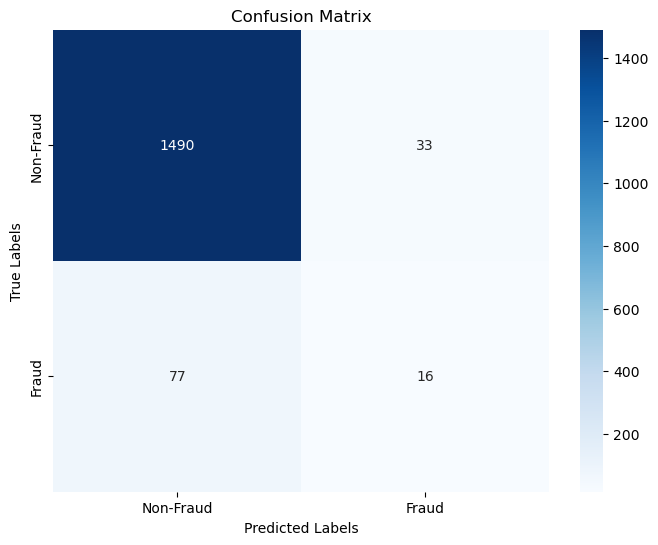

In [41]:
# function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names=['Non-Fraud', 'Fraud'], title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# function to evaluate the model and print metrics
def evaluate_model(model_dict, model_name, test_images, test_labels, threshold=0.5):
    model = model_dict.get('rf_classifier')
    pca = model_dict.get('pca')
    
    if model is None or pca is None:
        raise ValueError(f"{model_name} model or PCA is missing in the dictionary.")
    
    # flatten and transform test images
    if len(test_images.shape) > 2:
        test_images = test_images.reshape(test_images.shape[0], -1)
    test_images_pca = pca.transform(test_images)
    
    # get predictions and probabilities
    test_probs = model.predict_proba(test_images_pca)[:, 1]  # Positive class (Fraud)
    final_predictions = (test_probs > threshold).astype(int)
    
    # calculate performance metrics
    metrics = {
        "Accuracy": accuracy_score(test_labels, final_predictions),
        "Precision": precision_score(test_labels, final_predictions),
        "Recall": recall_score(test_labels, final_predictions),
        "F1 Score": f1_score(test_labels, final_predictions),
        "ROC AUC": roc_auc_score(test_labels, test_probs),
        "Average Precision": average_precision_score(test_labels, test_probs),
        "Confusion Matrix": confusion_matrix(test_labels, final_predictions),
        "ROC Curve": roc_curve(test_labels, test_probs),
        "Classification Report": classification_report(test_labels, final_predictions, target_names=['Non-Fraud', 'Fraud'])
    }
    
    # print key metrics
    print(f"{model_name} Model Metrics:")
    print(f"Threshold: {threshold}")  
    print(f"Accuracy: {metrics['Accuracy'] * 100:.2f}%")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("\nClassification Report:\n", metrics["Classification Report"])
    
    # plot confusion matrix
    plot_confusion_matrix(metrics["Confusion Matrix"])
    
    return metrics

# evaluate the model
metrics = evaluate_model(
    aug_rf_test_classification_model, 
    'Random Forest Binary Classification', 
    aug_rf_test_images_reshaped, 
    aug_rf_test_labels
)

### Function to Load Unlabeled Validation Images
The below function allows for loading images from validation dataset without requiring labels.

In [43]:
# function to load unlabelled validation images from the directory
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):  # Check if the file is an image
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # load image
                image = img_to_array(image)  # convert to array
                images.append(image)
                
                # Append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [44]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


# Validation Predictions on Denoised Images

In this section, we process the denoised validation images by predicting their labels using the trained Random Forest (RF) model. The predictions help determine whether the images are classified as fraudulent or non-fraudulent.

### Image Reshaping:
- The denoised validation images are reshaped back to their original size of **128x128** pixels with **3** color channels (RGB) to prepare them for classification.

### Model Loading:
- The trained RF model is loaded from the file named `rf_aug_with_pca.pkl` to be used for predicting the labels of the validation images.

### Prediction Process:
- Probabilities for the reshaped validation images are predicted using the loaded classification model. 
- The predicted probabilities are converted into binary labels by rounding them to the nearest integer (0 for non-fraud, 1 for fraud) and flattening the result into a one-dimensional array.

### Shape Verification:
- The shapes of the reshaped validation images and the predicted labels are printed to confirm they are formatted correctly for further evaluation.

In [46]:
# check contents of the validation directory
print(f"Checking contents of the validation directory: {val_dir}")
for root, dirs, files in os.walk(val_dir):
    print(f"Root: {root}, Files: {files}")

# specify the model file name
aug_rf_model_name = 'rf_aug_with_pca.pkl'

# check if the model file exists
if os.path.exists(aug_rf_model_name):
    print(f"Model file '{aug_rf_model_name}' found. Loading the model...")
    # Load the Random Forest model using joblib (since it's a .pkl file)
    aug_rf_classification_model = joblib.load(aug_rf_model_name)
    print(f"Model '{aug_rf_model_name}' loaded successfully.")
else:
    print(f"Model file '{aug_rf_model_name}' not found. Creating a placeholder model.")
    aug_rf_classification_model = {
        'rf_classifier': RandomForestClassifier(),
        'pca': PCA(n_components=50)
    }
    print("Placeholder model created.")

Checking contents of the validation directory: vehicle_insurance_dataset/sol
Root: vehicle_insurance_dataset/sol, Files: ['9733.jpg', '10321.jpg', '10447.jpg', '9055.jpg', '9041.jpg', '10453.jpg', '10335.jpg', '9727.jpg', '8439.jpg', '11003.jpg', '8411.jpg', '8377.jpg', '9069.jpg', '8363.jpg', '8405.jpg', '11017.jpg', '10309.jpg', '9928.jpg', '9096.jpg', '8388.jpg', '10484.jpg', '10490.jpg', '9082.jpg', '9914.jpg', '9900.jpg', '9257.jpg', '8149.jpg', '10645.jpg', '10123.jpg', '9531.jpg', '9525.jpg', '10137.jpg', '11229.jpg', '10889.jpg', '10651.jpg', '9243.jpg', '10679.jpg', '8175.jpg', '8613.jpg', '11201.jpg', '11215.jpg', '8607.jpg', '9519.jpg', '8161.jpg', '10686.jpg', '9294.jpg', '8834.jpg', '8820.jpg', '9280.jpg', '10692.jpg', '10862.jpg', '8808.jpg', '10876.jpg', '9323.jpg', '10731.jpg', '11349.jpg', '10057.jpg', '9445.jpg', '8983.jpg', '9451.jpg', '8997.jpg', '10043.jpg', '10725.jpg', '9337.jpg', '11413.jpg', '9479.jpg', '8767.jpg', '11375.jpg', '11361.jpg', '8773.jpg', '10719.j

# Model Validation and Prediction Process

In this section, we validate that the loaded Random Forest (RF) classification model is in the correct format and apply the model to the validation images.

### Validation of Model Contents:
- First, we ensure that the loaded model is a dictionary containing both the `rf_classifier` and `pca` components. If these components are found, we proceed to the next steps.

### Image Flattening and PCA Transformation:
- The validation images are flattened and transformed using the PCA model before feeding them into the Random Forest model for prediction.

### Prediction Process:
- We predict the labels for the validation images using the Random Forest model. The predicted probabilities are rounded to obtain binary labels (0 for non-fraud, 1 for fraud).
  
### Shape Verification:
- The shapes of the reshaped validation images and the predicted labels are printed to confirm that they are correctly formatted for further analysis.

In [48]:
# validate that the model is a dictionary containing 'rf_classifier' and 'pca'
if isinstance(aug_rf_classification_model, dict):
    model = aug_rf_classification_model.get('rf_classifier')
    pca = aug_rf_classification_model.get('pca')

    if model and pca:
        # flatten and apply PCA to the validation images before prediction
        aug_rf_val_images_reshaped = val_images.reshape(val_images.shape[0], -1)
        aug_rf_val_images_pca = pca.transform(aug_rf_val_images_reshaped)

        # predict using the Random Forest model
        aug_rf_val_probs = model.predict(aug_rf_val_images_pca)
        aug_rf_val_labels = aug_rf_val_probs.round().astype(int).flatten()

        # verify the shape of the validation images and labels
        print(f"Validation Images Shape: {aug_rf_val_images_reshaped.shape}")
        print(f"Predicted Validation Labels Shape: {aug_rf_val_labels.shape}")
    else:
        raise ValueError("Model or PCA not found in the dictionary.")
else:
    raise TypeError("aug_rf_classification_model is not a dictionary.")

Validation Images Shape: (3462, 49152)
Predicted Validation Labels Shape: (3462,)


# Data Validation and Prediction Storage

### Image and Label Length Check:
- The script verifies that the number of image paths and corresponding labels are consistent. If there is a mismatch between the number of images and labels, it raises an error, ensuring data integrity.

### Storing Predictions:
- A DataFrame is created to store the predictions, linking each image path to its predicted label. This structure will allow easy access to the predictions for further analysis or saving to a file.

In [50]:
# verify the lengths of image paths and labels
aug_rf_val_image_paths = [os.path.join(val_dir, file) for file in os.listdir(val_dir) if is_image_file(file)]
if len(aug_rf_val_image_paths) != len(aug_rf_val_labels):
    raise ValueError("Mismatch between the number of images and labels. Check your data.")

# create a DataFrame for predictions
aug_rf_val_predictions = pd.DataFrame({
    'image_path': aug_rf_val_image_paths,
    'predicted_label': aug_rf_val_labels
})

# Post-Prediction Processing and Export

### Classification Column:
- A new column named 'classified' is added to the predictions DataFrame. It maps the predicted labels (0 for non-fraud, 1 for fraud) into readable categories ('fraud' and 'non-fraud').

### Count of Predictions:
- The number of 'fraud' and 'non-fraud' predictions are printed to provide insight into the distribution of the model's predictions on the validation dataset.

### Exporting Predictions:
- The predictions are saved to a CSV file named `aug_rf_validation_predictions.csv`, ensuring the results can be easily reviewed or further processed.

In [52]:
# add a 'classified' column based on the 'predicted_label'
aug_rf_val_predictions['classified'] = aug_rf_val_predictions['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

# print counts of 'fraud' and 'non-fraud' predictions
print('Fraud count:', aug_rf_val_predictions[aug_rf_val_predictions['predicted_label'] == 1].shape[0])
print('Non-Fraud count:', aug_rf_val_predictions[aug_rf_val_predictions['predicted_label'] == 0].shape[0])

# export predictions to CSV
output_path = 'aug_rf_validation_predictions.csv'
aug_rf_val_predictions.to_csv(output_path, index=False)
print(f"Validation predictions have been exported to {output_path}")

Fraud count: 933
Non-Fraud count: 2529
Validation predictions have been exported to aug_rf_validation_predictions.csv


# Visualizing Fraud and Non-Fraud Predictions

### Image Display:
- This section visualizes a few sample fraud and non-fraud images from the validation set, along with their predicted labels.
- The images are displayed in a 2xN grid, where the top row shows fraud images and the bottom row shows non-fraud images. Each image is labeled with its predicted classification.

### Image Preprocessing:
- The images are resized to **128x128** pixels to match the expected input shape of the Random Forest model and are normalized to have pixel values between **0 and 1**.

### Random Sampling:
- The function samples **5 fraud** and **5 non-fraud** images (or fewer if less than 5 of each type are available) to ensure a diverse representation from the validation dataset.

In [54]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your rf
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

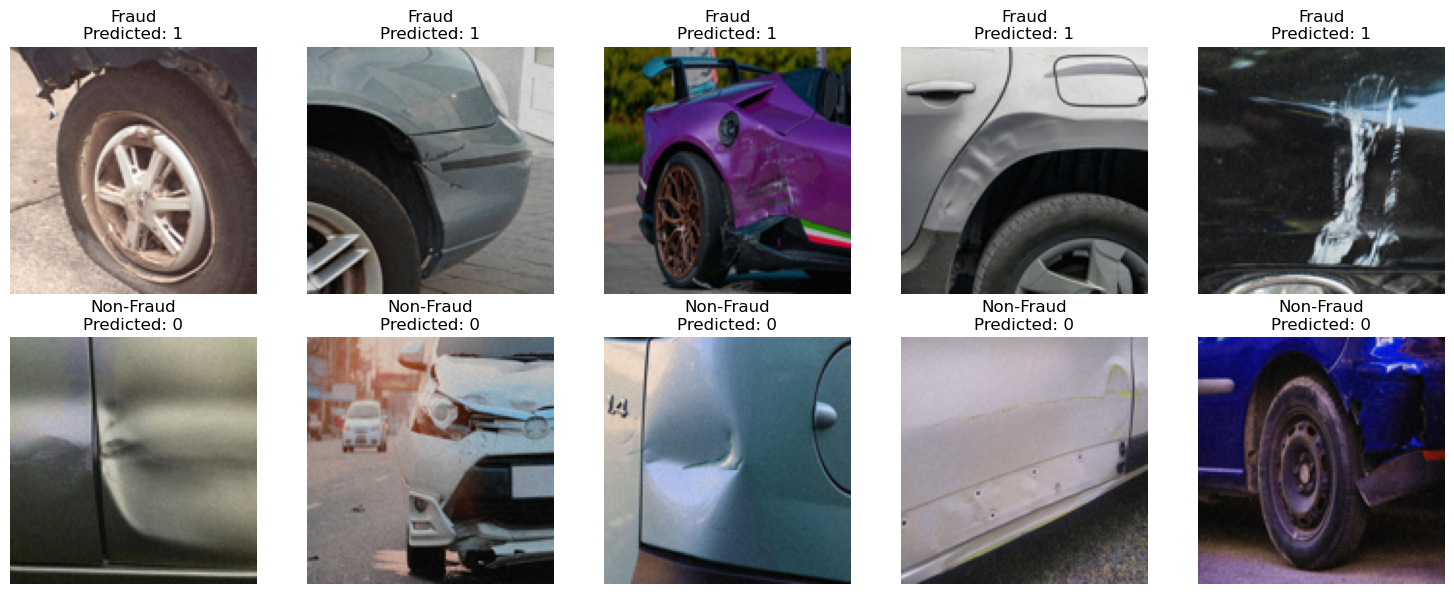

In [55]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(aug_rf_val_predictions, n=5)